# Ballon D'or winner prediction model

Author: Caroline Cheng

Course Project, UC Irvine, Math 10, Fall 24

I would like to post my notebook on the course's website. [Yes]

## Introduction

The $Ballon \: d'Or$ or $Golden \: Ball$ is a football award presented annually by French magazine France football. The winner is decided by the votes from 100 journalists from 100 nations, and it is considered the most presitigious individual award given out in football. Because of the nature of its selection process, it has often been accused of being biased. In my project, I will endeavor to create models to predict the winner based on past data of the top 3 candidates starting from 1956.

The dataset is partly obtained from Kaggle [Golden Ball winners](https://www.kaggle.com/code/midouazerty/golden-ball-winner-prediction/notebook), but as it only records from 1990-2019, I manually gathered rest of the data from [Transfermarkt](transfermarkt.com), so there might be mistakes in the dataset.Apart from the numerical variables in the orginal dataset, I also included categorical variables that might influence the media in the voting process.

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('BallonDor.csv')
df

,Year,Rank,Player,Country,Team,Points,Percentage,Goal,Assist,Goal&Assist,Appearences,Minute Played,League winner,World Cup winner,Champions League winner,European/American Champion
0,1956,1st,Stanley Matthews,England,Blackpool,47,37.90,3.0,1.0,4.0,36.0,3240.0,0,0,0,0
1,1956,2nd,Alfredo Di Stefano,Spain,Real Madrid,44,35.48,29.0,3.0,32.0,37.0,3296.0,1,0,1,0
2,1956,3rd,Raymond Kopa,France,Real Madrid,33,26.61,9.0,2.0,11.0,42.0,3810.0,1,0,1,0
3,1957,1st,Alfredo Di Stefano,Spain,Real Madrid,72,58.54,40.0,1.0,41.0,40.0,3600.0,1,0,1,0
4,1957,2nd,Billy Wright,England,Wolverhampton Wanderers,19,15.45,0.0,0.0,0.0,40.0,3600.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2023,2nd,Erling Haaland,Norway,Manchester City,357,24.25,55.0,10.0,65.0,56.0,4149.0,1,0,1,0
202,2023,3rd,Kylian Mbappe,France,Paris Saint-Germain,270,18.34,46.0,11.0,57.0,58.0,4836.0,1,0,0,0
203,2024,1st,Rodri,Spain,Manchester City,NaN,NaN,10.0,12.0,22.0,42.0,3657.0,1,0,0,1
204,2024,2nd,Vinicius Junior,Brazil,Real Madrid,NaN,NaN,21.0,11.0,32.0,49.0,3420.0,1,0,1,0


In the process of data gathering, it was noticed that some old match statistics were lost. Not only does this result in NaN values, but also Appearences under 10 game per season should be considered irregular value, persumably with data missing, thus be droped from the dataset.

In [188]:
df = df.dropna()
df= df[df['Appearences'] >= 10]
df.shape

(190, 16)

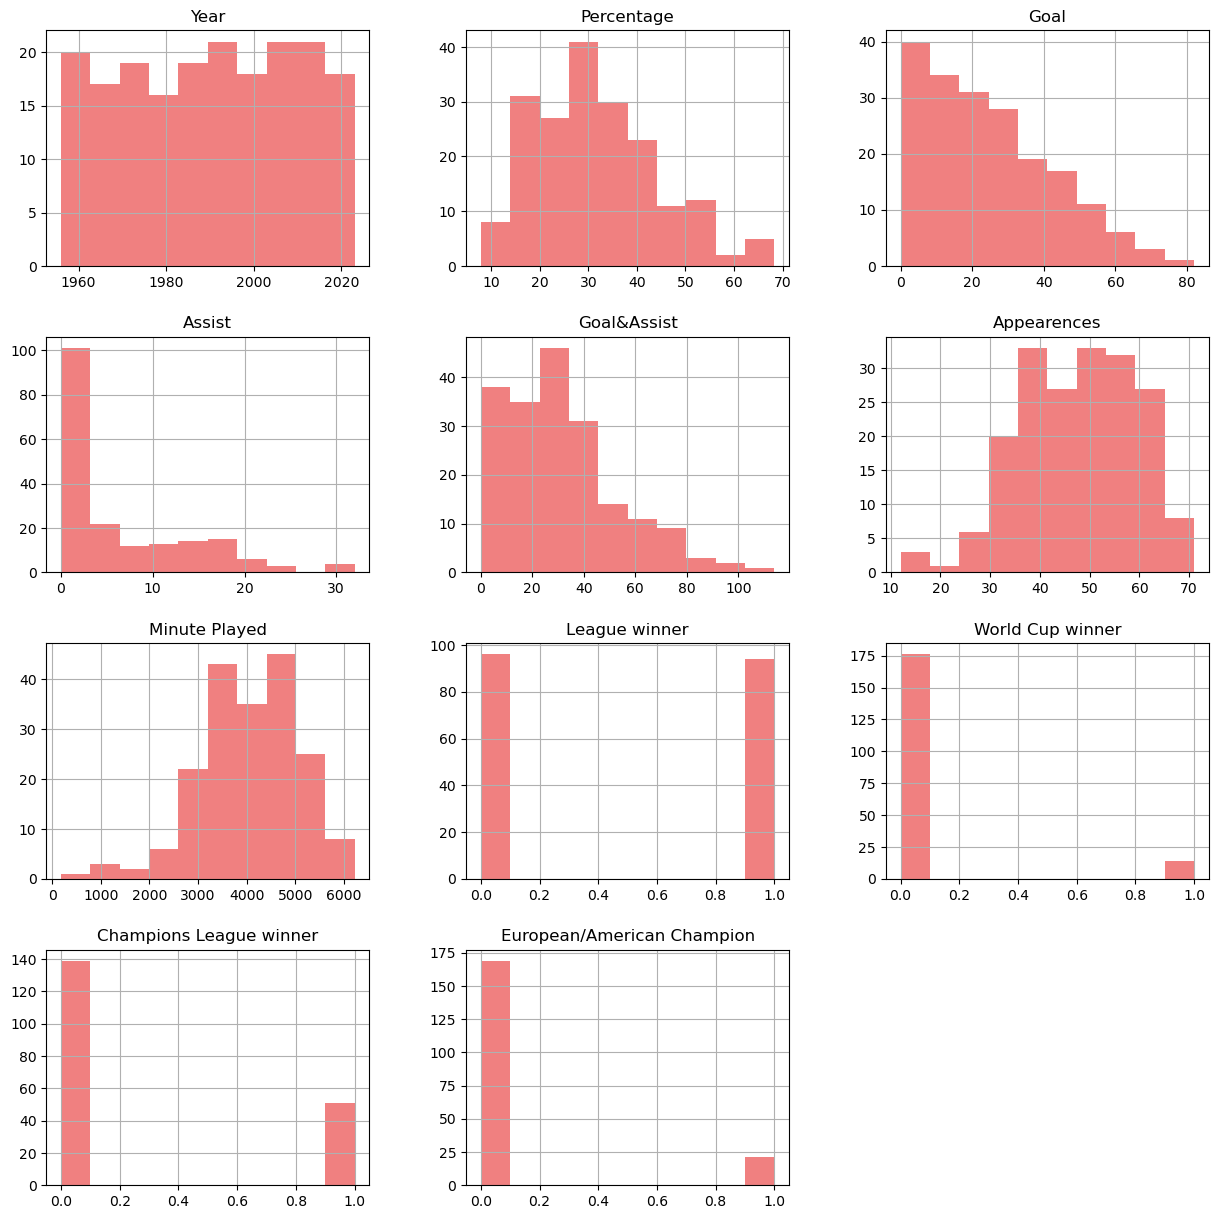

In [189]:
df.hist(figsize=(15,15), color ='lightcoral' )
plt.show()

Observing the histograms, only appearences mimic a normal distribution, despite skewed. And this is likely because of the different positions of the nominated players, with defender less likely to score goals, while tackle and saves are not taken into consideration in the dataset.

## Linear Model
When constructing a linear model, here it is inappropriate to chose 'points' as the dependent variable, as the voting pool changes through out the year. Instead, here voting percentage is selected, and I will explore its relationship with the features listed.

In [190]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
lreg = linear_model.LinearRegression()
features = ['Goal','Assist','Goal&Assist','Appearences','Minute Played','League winner','World Cup winner','Champions League winner','European/American Champion']
target = 'Percentage'
X = df[features]
y = df[target]
lreg.fit(X,y)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(lreg, X, y, cv=kf, scoring='r2')
print(lreg.intercept_, lreg.coef_)
print(f"Cross-validation R-squared scores: {scores}")
print(f"Mean R-squared: {scores.mean():.2f}")

27.175648010396774 [ 2.31614465e-01 -2.15644976e-01  1.59694891e-02 -2.69606173e-01
  2.09217861e-03  3.74469979e+00  6.26245072e+00  4.53470715e+00
  4.47881424e+00]
Cross-validation R-squared scores: [ 0.10353805 -0.33216812 -0.16985669  0.03861227  0.20722174 -0.17414298
  0.01787353  0.22357425  0.03092169  0.02594003]
Mean R-squared: -0.00


While a prelinminary multiple linear model is fitted, the $R^2$ is shockingly low. In an attempt to fix this, one might suspect that this problem is due to that some of the features has a high correlation that results in colinearity,and now we attempt to find a model with the best $R^2$.

In [191]:
from itertools import combinations
from sklearn.model_selection import train_test_split
all_subsets = []
for i in range(len(features)):
    subsets = list(combinations(features,i))
    all_subsets.extend(subsets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
result = []
for i in range(1, len(features) + 1):
    for subset in combinations(features, i):
        X_train_subset = X_train[list(subset)]
        X_test_subset = X_test[list(subset)]
        lreg.fit(X_train_subset, y_train)
        R_2_train = lreg.score(X_train_subset, y_train)
        R_2_test = lreg.score(X_test_subset, y_test)
        result.append({'features': subset, 'train R^2' :R_2_train, 'test R^2' :R_2_test})
result_df = pd.DataFrame(result)
best_model = result_df.loc[result_df['test R^2'].idxmax()]
print(result_df)
print(best_model)

                                              features  train R^2  test R^2
0                                              (Goal,)   0.025082  0.028728
1                                            (Assist,)   0.009001 -0.039267
2                                       (Goal&Assist,)   0.024155  0.007181
3                                       (Appearences,)   0.020616 -0.069990
4                                     (Minute Played,)   0.037776 -0.096034
..                                                 ...        ...       ...
506  (Goal, Assist, Goal&Assist, Minute Played, Lea...   0.181901 -0.100499
507  (Goal, Assist, Appearences, Minute Played, Lea...   0.206424 -0.106873
508  (Goal, Goal&Assist, Appearences, Minute Played...   0.206424 -0.106873
509  (Assist, Goal&Assist, Appearences, Minute Play...   0.206424 -0.106873
510  (Goal, Assist, Goal&Assist, Appearences, Minut...   0.206424 -0.106873

[511 rows x 3 columns]
features     (Goal, Goal&Assist, World Cup winner, Champion...
t

Clearly, this does not solve the problem. And upon reflection, I have realized that the problem is likely due to in data selection, only the top 3 candidate were included in their data set, and voting percentage they gained does not differenciate as well as could be hoped. And since each individual feature has a low correlation with the final voting percentage, it suggest that it would be very likely to produce a significant model with these features combined.

Mean: 31.72
StandardDeviation: 12.54


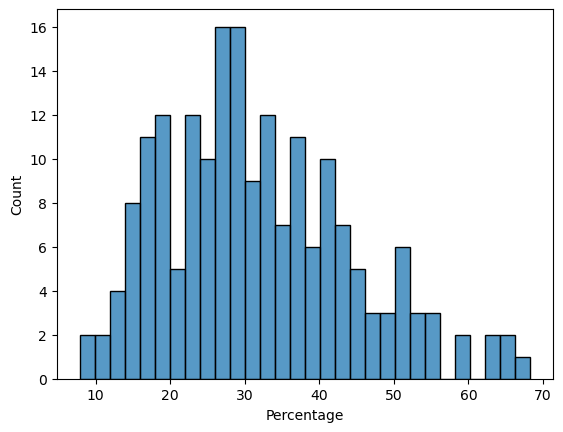

In [192]:
import seaborn as sns
sns.histplot(y,bins = 30)
y_bar = y.mean()
y_sd = y.std()
print(f'Mean: {y_bar:.2f}')
print(f'StandardDeviation: {y_sd:.2f}')
plt.show()

Again, we are able to see that voting percentage concentrate around 30 percent, which means that the top 3 candidates out of 30 holds the majority of votes among themselves, however, the distinction is not larget enough be to useful. It might be helpful if all 30 nominees are included.

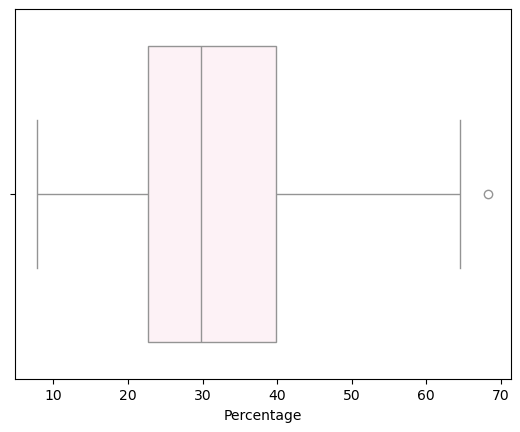

outliers:68.32
median: 29.80


In [193]:
sns.boxplot(x = y, color = 'lavenderblush')
y_median = y.median()
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = y[(y < lower_bound) | (y > upper_bound)]
plt.show()
for i in outliers:
    print(f'outliers:{i:.2f}')
print(f'median: {y_median:.2f}')

## Logistics Regression model
Classfying the players into those who won the golden ball that season and those who did not, we are able to perform logistics regression on the data, with the hope that the relevence would be prove to be stronger than that of the linear models.

In [194]:
df['GoldenBall winner'] = df['Rank'].apply(lambda x: 1 if x == '1st' else 0)
new_target = 'GoldenBall winner'
y = new_target

In [195]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
df_train, df_test = train_test_split(df, test_size=0.5, random_state=0, stratify=df['GoldenBall winner'])
train_X = df_train[features]
train_y = df_train['GoldenBall winner']
test_X = df_test[features]
test_y = df_test['GoldenBall winner']
clf = LogisticRegression(C=1e10, max_iter=10000)
clf.fit(train_X,train_y)
train_pred = clf.predict(train_X)
test_pred = clf.predict(test_X)
train_accuracy = accuracy_score(train_y, train_pred)
test_accuracy = accuracy_score(test_y,test_pred)
print(f'training_accuracy = {train_accuracy}')
print(f'tesing_accuracy = {test_accuracy}')

training_accuracy = 0.7368421052631579
tesing_accuracy = 0.6631578947368421


While the accuracy are reasonably acceptable, the warning about exceeding interations and unable to get the best result suggest that Regulation would be of use to enhance the model.

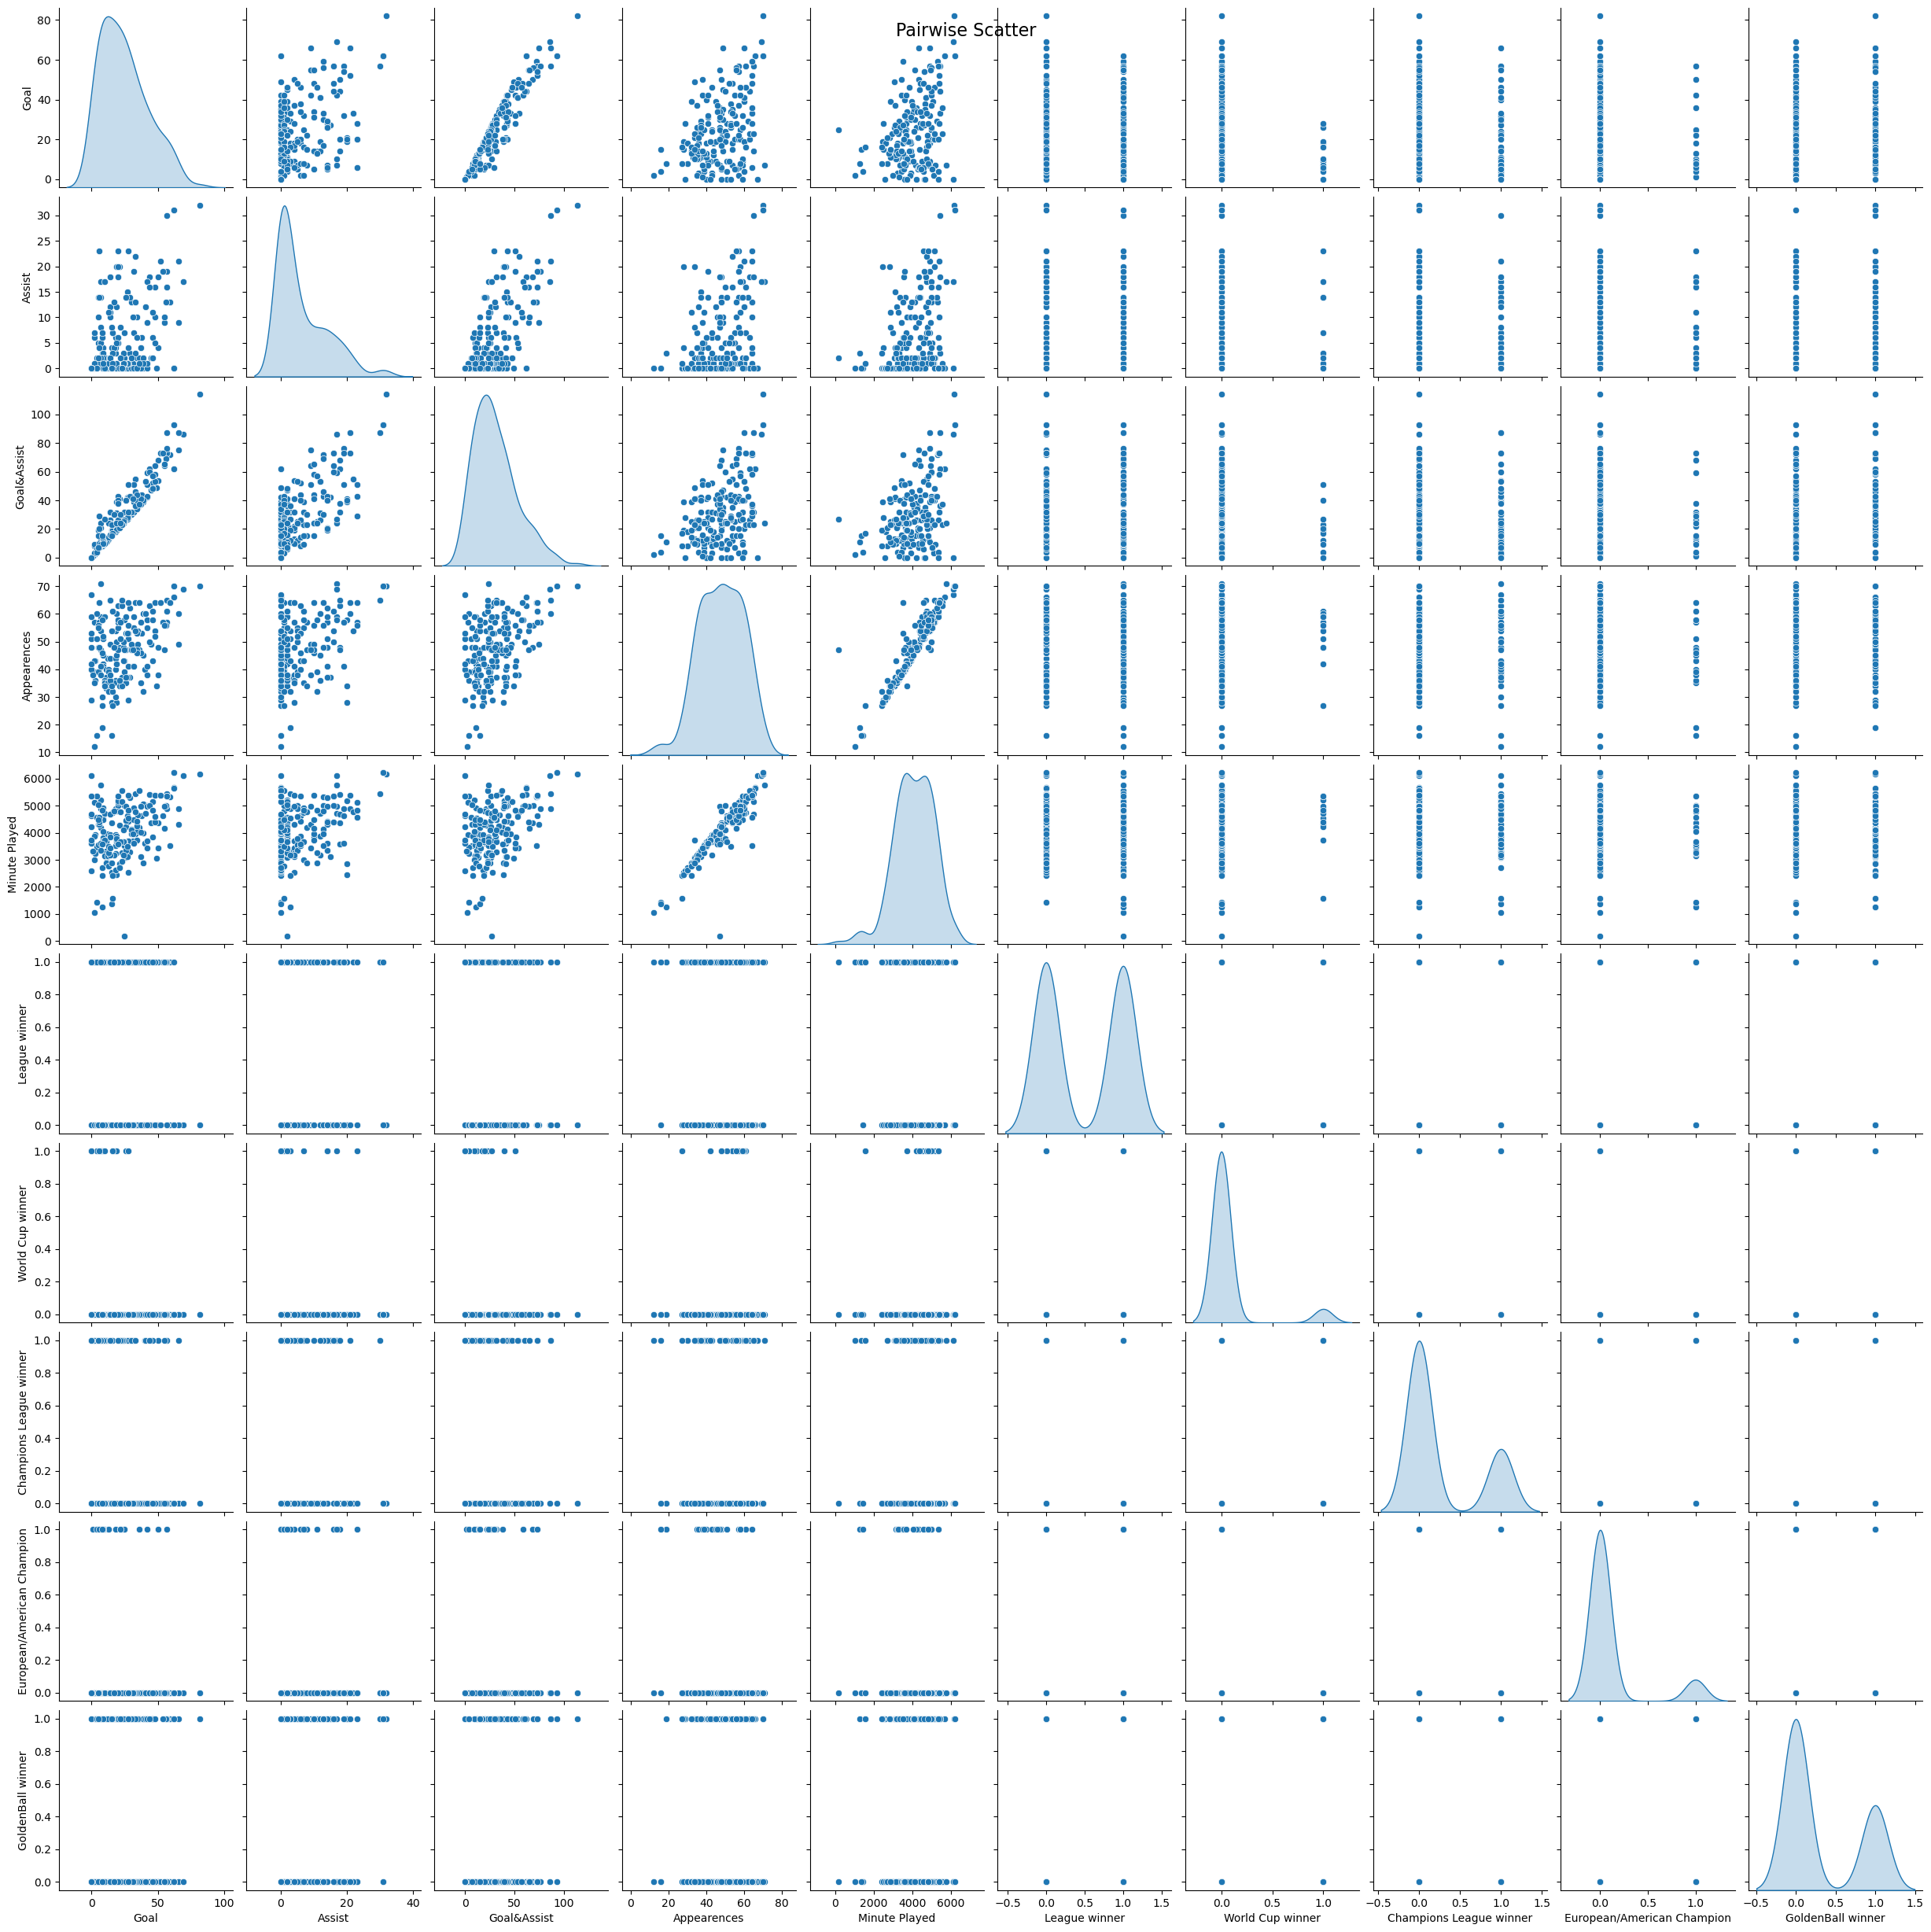

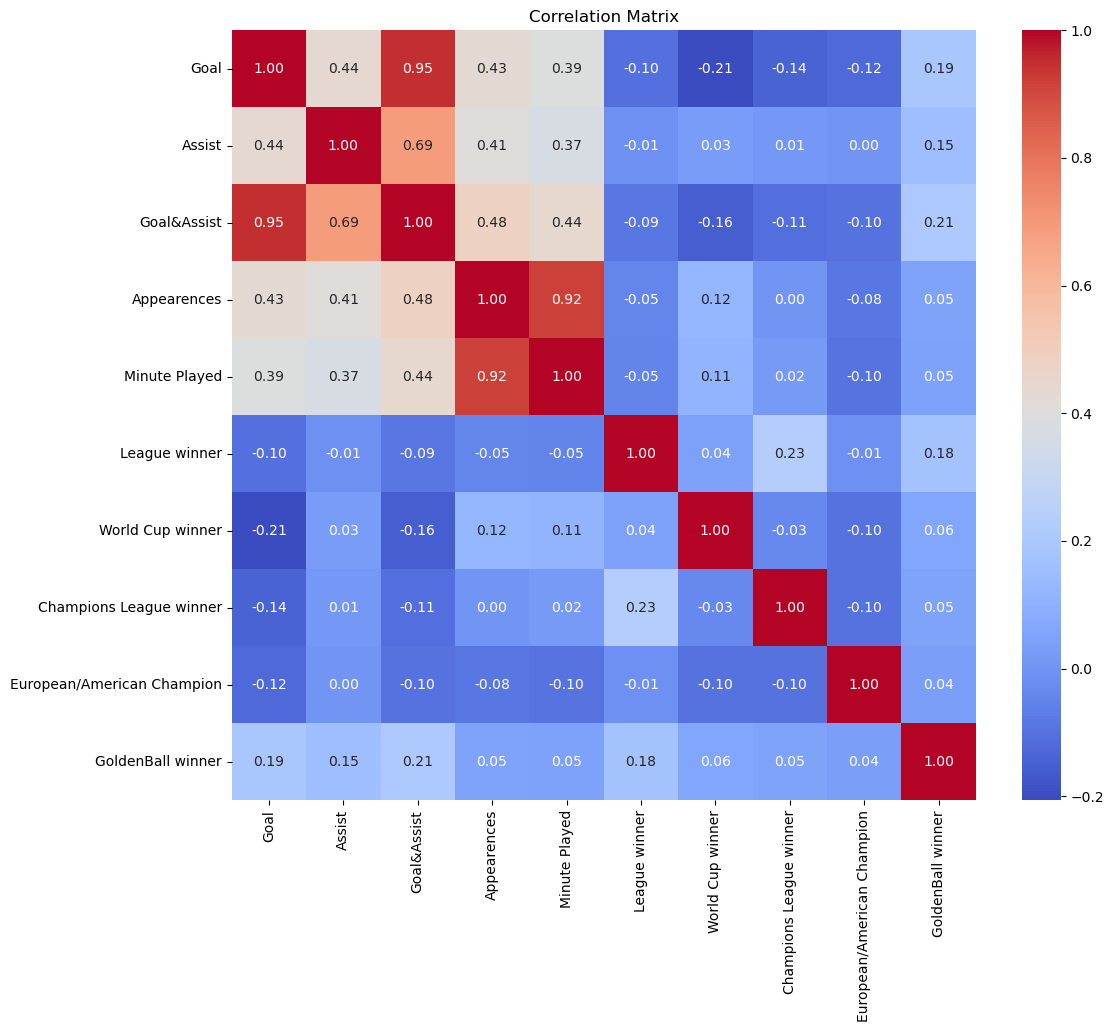

In [196]:
sns.pairplot(df[features + [new_target]], diag_kind='kde')
plt.suptitle('Pairwise Scatter', size=16)
plt.show()
plt.figure(figsize=(12, 10))
corr_matrix = df[features + [new_target]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

Again, one is disappointed to see that the winner of Ballon d'Or does not share a high correlation with any of the features.But it makes sense that the highest is the League winner, since it calls for consistancy, a strong performance across the season.
Evidently, the team honors are very much unrelated with each other. For one reason, world cup and continental cups takes place every 4 year and that is not reflected in the dataset; for another, the best team does not always win the treble.

### Regulation
Ridge and lasso regression are attempted here.


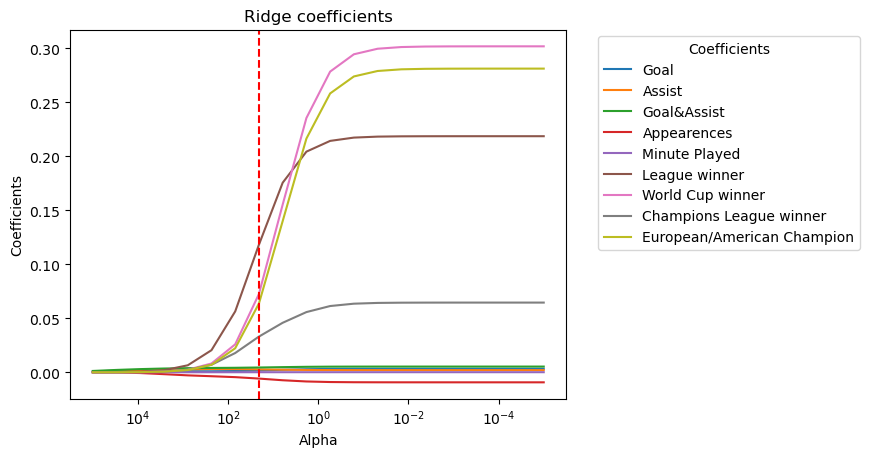

coefficient at min_test_error_alpha: [ 1.70403155e-03  2.75297326e-03  4.45700480e-03 -5.78246731e-03
  9.62133909e-05  1.18181744e-01  7.25374979e-02  3.30884082e-02
  6.36961021e-02]
Alpha with minimum testing error: 20.6913808111479
Mean test MSE: 0.232


In [197]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
df_cleaned = df.dropna(subset=features + ['GoldenBall winner'])
X = df_cleaned[features]
y = df_cleaned['GoldenBall winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
alphas = np.logspace(5, -5, 20)
coefficients = np.zeros((len(alphas), X_train.shape[1]))
train_mse = []
test_mse = []
for index, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    coefficients[index, :] = ridge.coef_
min_test_error_alpha = alphas[np.argmin(test_mse)]
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
best_coef = coefficients[np.argmin(test_mse)]
print(f'coefficient at min_test_error_alpha: {best_coef}')
min_test_error_alpha = alphas[np.argmin(test_mse)]
print(f"Alpha with minimum testing error: {min_test_error_alpha}")
print(f"Mean test MSE: {np.mean(test_mse):.3f}")

This MSE is far from ideal --- close to 0 or 1, and we move on to the lasso regression.

Lasso Regression

/Users/carolinecheng/anaconda3/envs/math9/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 2.211e-03
  model = cd_fast.enet_coordinate_descent(
/Users/carolinecheng/anaconda3/envs/math9/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 2.211e-03
  model = cd_fast.enet_coordinate_descent(
/Users/carolinecheng/anaconda3/envs/math9/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

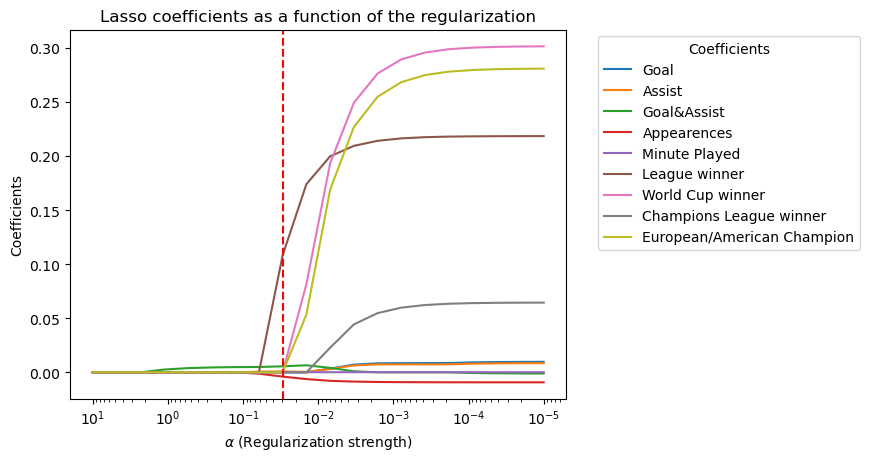

coefficient at min_test_error_alpha: [ 0.00000000e+00  8.47869294e-04  5.53823475e-03 -3.97596641e-03
  8.57613711e-05  1.08417635e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


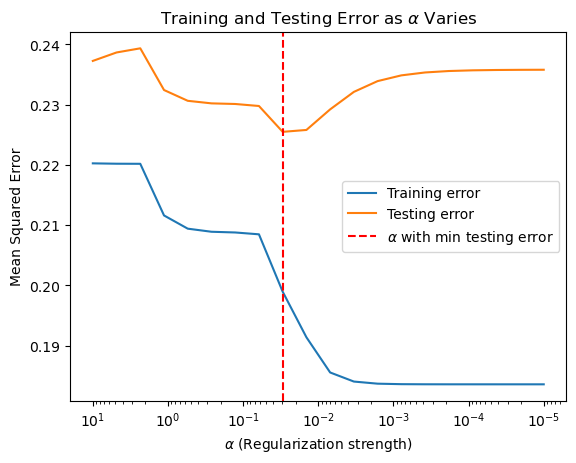

Alpha with minimum testing error: 0.06158482110660267
Mean test MSE: 0.232


In [198]:
from sklearn.linear_model import Lasso
alphas = np.logspace(1, -5, 20)
coefficients = np.zeros((len(alphas), X_train.shape[1]))
train_errors = []
test_errors = []
for index, alpha in enumerate(alphas):
    ridge = Lasso(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    coefficients[index, :] = ridge.coef_
min_test_error_alpha = alphas[np.argmin(test_errors)]
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
best_coef = coefficients[np.argmin(test_errors)]
print(f'coefficient at min_test_error_alpha: {best_coef}')
plt.figure()
plt.plot(alphas, train_errors, label='Training error')
plt.plot(alphas, test_errors, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()
min_test_error_alpha = alphas[np.argmin(test_mse)]
print(f"Alpha with minimum testing error: {min_test_error_alpha}")
print(f"Mean test MSE: {np.mean(test_mse):.3f}")

While the MSE remains unsatisfying, the lasso regression helps to select the features that are relatively more influential in this case, so we try fitting our model around them.

In [199]:
from sklearn.preprocessing import StandardScaler
new_features = ['Assist','Goal&Assist','Appearences','Minute Played','League winner']
X = df_cleaned[new_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
log_scores = cross_val_score(clf, X_scaled, y, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy scores: {log_scores}")
print(f"Mean Accuracy: {log_scores.mean():.2f}")

Cross-validation Accuracy scores: [0.73684211 0.68421053 0.73684211 0.68421053 0.73684211 0.36842105
 0.52631579 0.63157895 0.78947368 0.73684211]
Mean Accuracy: 0.66


Removing the features does not improve accuracy. But since the model is already here, it might as well be tested.

## Model Testing & p values

In [200]:
import statsmodels.api as sm
X_new = sm.add_constant(X)
model = sm.Logit(y,X_new)
fitted = model.fit()
log_likelihood_model = fitted.llf
null_model = sm.Logit(y, np.ones((len(X), 1))) 
null_result = null_model.fit()
LL_Null = null_result.llf
llr_p_value = fitted.llr_pvalue
pseudo_r_squared = 1 - (log_likelihood_model / LL_Null)
print(f"Pseudo R²: {pseudo_r_squared:.4f}")
print(f"Log-Likelihood: {log_likelihood_model:.2f}")
print(f"LL-Null: {LL_Null:.2f}")
print(f"LLR p-value: {llr_p_value:.3e}")

Optimization terminated successfully.
         Current function value: 0.592953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635291
         Iterations 4
Pseudo R²: 0.0666
Log-Likelihood: -112.66
LL-Null: -120.71
LLR p-value: 6.596e-03


The pseudo $R^2$ works for logistics model similar as $R^2$ works for linear model, and the value is relatively low, which again tells of the model does not fit the data well. And a log-likelihood of -112.66 suggests that the model’s likelihood of producing the observed data is low, being an extreme negative. The p-value from the likelihood ratio test is much smaller than the 0.05 threshold and indicates that the model is statistically significantly better than the null model, or that the features included in the model have predictive power.

In [201]:
cov = fitted.cov_params()
std_err = np.sqrt(np.diag(cov))
print("Covariance Matrix:")
print(cov)
print("Standard Errors:")
print(std_err)

Covariance Matrix:
                  const        Assist   Goal&Assist  Appearences  \
const          0.536653  3.436003e-03 -1.213660e-04    -0.006951   
Assist         0.003436  8.653590e-04 -1.945834e-04    -0.000054   
Goal&Assist   -0.000121 -1.945834e-04  1.135842e-04    -0.000050   
Appearences   -0.006951 -5.396994e-05 -5.013244e-05     0.001153   
Minute Played -0.000037  5.062147e-08 -5.376034e-08    -0.000011   
League winner -0.078515 -7.528776e-04  5.137799e-04    -0.000236   

               Minute Played  League winner  
const          -3.742816e-05      -0.078515  
Assist          5.062147e-08      -0.000753  
Goal&Assist    -5.376034e-08       0.000514  
Appearences    -1.128242e-05      -0.000236  
Minute Played   1.411334e-07       0.000004  
League winner   4.280722e-06       0.108424  
Standard Errors:
[7.32565877e-01 2.94169840e-02 1.06575879e-02 3.39538768e-02
 3.75677224e-04 3.29278292e-01]


In [202]:
p_values = fitted.pvalues
z_values = fitted.params / std_err
print("P-values:")
print(p_values)
print("Z-values:")
print(z_values)

P-values:
const            0.062001
Assist           0.951019
Goal&Assist      0.020250
Appearences      0.678451
Minute Played    0.962533
League winner    0.008201
dtype: float64
Z-values:
const           -1.866292
Assist           0.061427
Goal&Assist      2.321678
Appearences     -0.414578
Minute Played    0.046975
League winner    2.643670
dtype: float64


Three features has p value greater than 0.05, indicating that it is not statisticly significant, and variable does not have a meaningful relationship to the target variable.But as the covariance are very low, it would not help much to remove them any ways.

## Conclusions
From all the far-from-ideal values above, it is clear that the model produced here are bad for prediction. However, in a realistic sense, this means that archivement in football is hard to be measure by the honors gained by each player, and team glory often does not coincide with individual effort.There are so much more to in consideration. And also, that the vote could be very much biased since it is not quite statistic related, so one might not be wrong when one complains about the award being rigged.